# <center> Lecture13 : Hierarchical Models </center>  
 
## <center> Instructor: Dr. Hu Chuan-Peng </center> 

## 回顾  

### 以随机点运动任务为例  

本节课我们依旧以**随机点运动任务**（Random Motion Dot Task）为例，之前的课中，我们仅选取一个被试的例子，但实际上在真实的心理学研究中，我们不会仅针对一个被试进行研究，针对多个被试的反应时间数据，我们要怎么建立模型呢？  

* 参与者的任务是判断这些点的主要移动方向（例如，向左还是向右）。  


![Image Name](https://cdn.kesci.com/upload/image/rkz1ehen1l.png?imageView2/0/w/720/h/960)  

<div style="padding-bottom: 30px;"></div>  



**反应时间数据的挑战：**  

* 被试间的差异：不同被试的反应时间可能有较大差异。  
* 数据偏倚：反应时间可能受到各种因素的影响（如疲劳、动机等），而这些因素在被试间是不一致的。  


* 与传统的频率学派方法不同，贝叶斯方法能够将先验信息（例如，关于群体或个体的预期分布）与数据结合，通过推断逐步修正不确定性，从而得出更精确的估计。  

* 对于多个被试的反应时间数据，贝叶斯层级模型通过引入“群体层”和“个体层”，在建模过程中既考虑到个体差异，也能够捕捉到群体总体趋势，从而更全面地理解反应时间数据背后的复杂结构。


### 大纲  
在本节课中，我们将介绍层级模型(hierarchical model)。主要内容：  
- 了解层级数据结构的形式  
- 三种对待处理层级数据的思路：完全池化(complete pooling),  非池化(no pooling), 部分池化(patial pooling)  
- 了解组间变异(between variability)和组内变异(within variability)的差异  
- 通过pymc实现三种不同的模型，并理解分层模型的意义  

> 注：层级模型有许多别名，多层线性模型（Hierarchical Linear Model，HLM），也叫多水平模型（Multilevel Model，MLM），线性混合模型（Linear Mixed Model）混合效应模型（Mixed Effects Model）随机效应模型（Random Effects Model)

## 层级数据结构  

在心理学实验中，层级数据或分组数据(hierarchical or grouped data)十分常见，例如：  

1. 设计不同的实验条件，在同一实验条件下收集多个数据(实验条件为组)  
2. 划分不同的人群，在同类人群中收集多个数据(人群为组)  
3. 在一种实验条件内，被试需要重复对同种刺激做出反应(被试为组)  

同时，根据下图可以看出，尽管数据内容有所不同，但其层级结构具有高度相似性，均呈现出分层式的组织方式。

无论是学校-系-被试的层次，还是群体-被试-反应时间的结构，数据的组织逻辑都体现为从整体到局部的逐级细分。

![Image Name](https://cdn.kesci.com/upload/sod2y12sei.png?imageView2/0/w/960/h/960)


在之前使用的数据中，层级数据表现为来自多个被试的反应时间数据。

In [1]:
# 导入 pymc 模型包，和 arviz 等分析工具 
import pymc as pm
import arviz as az
import seaborn as sns
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import ipywidgets
import bambi as bmb

# 忽略不必要的警告
import warnings
warnings.filterwarnings("ignore")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
# 使用 pandas 导入示例数据
try:
  df_raw  = pd.read_csv("/home/mw/input/bayes3797/evans2020JExpPsycholLearn_exp1_full_data.csv") 
except:
  df_raw  = pd.read_csv('data/evans2020JExpPsycholLearn_exp1_full_data.csv')

df_raw[["subject","RT"]]

,subject,RT
0,31727,3529
1,31727,2242
2,31727,979
3,31727,4526
4,31727,7387
...,...,...
64707,84421,1214
64708,84421,870
64709,84421,942
64710,84421,4359


### 数据可视化  

对所有被试的反应时间的平均值进行可视化，可以发现  

* 不同被试的平均反应时间差异较大 

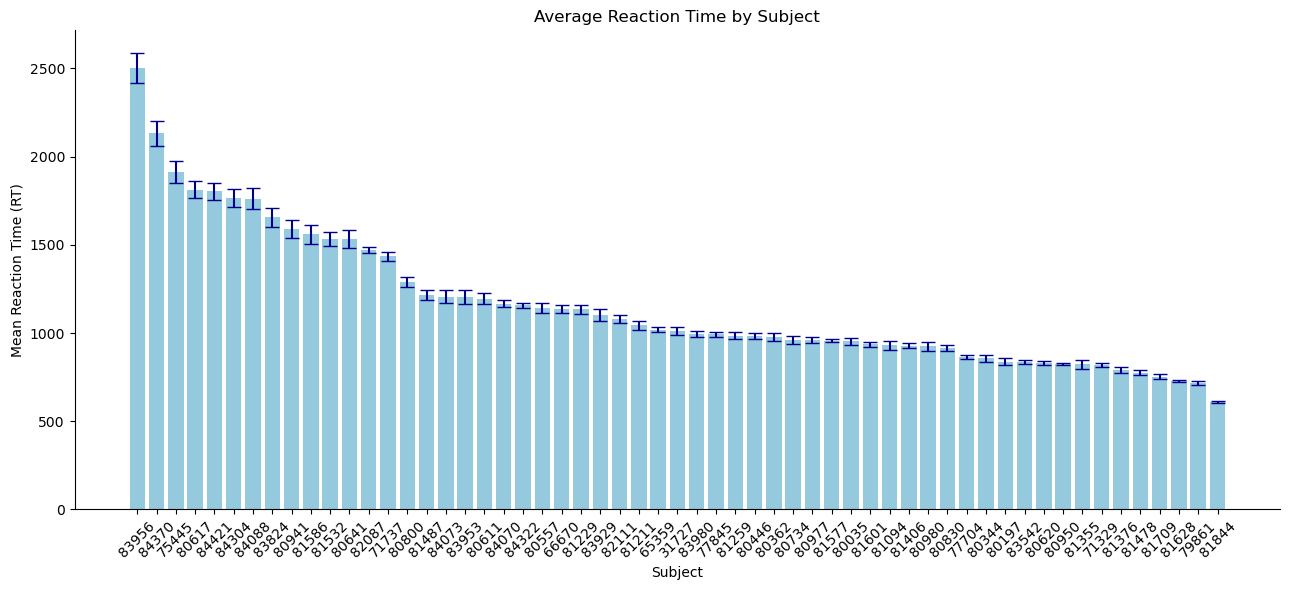

In [4]:
# 计算每个被试的平均反应时间和标准误差
subject_stats = df_raw.groupby("subject")["RT"].agg(['mean', 'std', 'count']).reset_index()
subject_stats['sem'] = subject_stats['std'] / np.sqrt(subject_stats['count'])

# 按照平均反应时间从高到低排序
subject_stats.sort_values(by="mean", ascending=False, inplace=True, ignore_index=True)
subject_stats.subject = subject_stats.subject.astype(str)

# 绘制平均反应时间的可视化
plt.figure(figsize=(13, 6))
sns.barplot(x="subject", y="mean", data=subject_stats, color = "skyblue")

# 添加误差线
for i, row in subject_stats.iterrows():
    plt.errorbar(x=i, y=row['mean'], yerr=row['sem'], linestyle='', capsize=5, color = "darkblue")

plt.title("Average Reaction Time by Subject")
plt.xlabel("Subject")
plt.ylabel("Mean Reaction Time (RT)")
plt.xticks(rotation=45)
plt.tight_layout()
sns.despine()
plt.show()

由于被试数量较多，为了使得之后的代码简单和结果清晰，仅使用其中5个被试的数据作为演示。

此外，为了保证数据更加“干净”，仅选择单一的percentCoherence 水平（即 5%）时的RT数据进行分析，避免多种条件混合带来的潜在偏差。

In [5]:
# 筛选出特定被试并创建索引
df_first5 = df_raw[df_raw['subject'].isin([81844, 83956, 83824, 66670, 80941]) & (df_raw['percentCoherence'] == 5)]

# 为每个被试建立索引 'subj_id' 和 'obs_id'
df_first5['subj_id'] = df_first5['subject']
df_first5['obs_id'] = df_first5.groupby('subject').cumcount() + 1

df_first5["log_RTs"] = np.log(df_first5["RT"])

df_first5.head()

,subject,blkNum,trlNum,coherentDots,numberofDots,percentCoherence,winningDirection,response,correct,eventCount,averageFrameRate,RT,subj_id,obs_id,log_RTs
2239,66670,2,2,2,40,5,left,left,1,23,15.700,1465,66670,1,7.289611
2240,66670,2,3,2,40,5,left,left,1,25,15.375,1626,66670,2,7.393878
2243,66670,2,6,2,40,5,left,left,1,16,16.113,993,66670,3,6.900731
2246,66670,2,9,2,40,5,left,left,1,13,15.385,845,66670,4,6.739337
2256,66670,2,19,2,40,5,left,left,1,27,15.341,1760,66670,5,7.473069


绘制每个被试在percentCoherence为5%时的反应时间直方图，以查看数据分布。 

* 可以发现，不同被试的反应时间分布存在差异，这可能是由于被试之间的个体差异造成的。
* 更重要的是，反应时的分布并不是正态分布，而是偏斜的。

为了正确对反应时分布进行建模，我们需要使用非正态分布的分布，或者将反应时求对数后再通过正态分布进行建模。

* 可以发现，在经过对数转换后，反应时的分布更加接近正态分布。
  
通过对比这两种反应时间分布，我们可以更好地理解数据的特性。

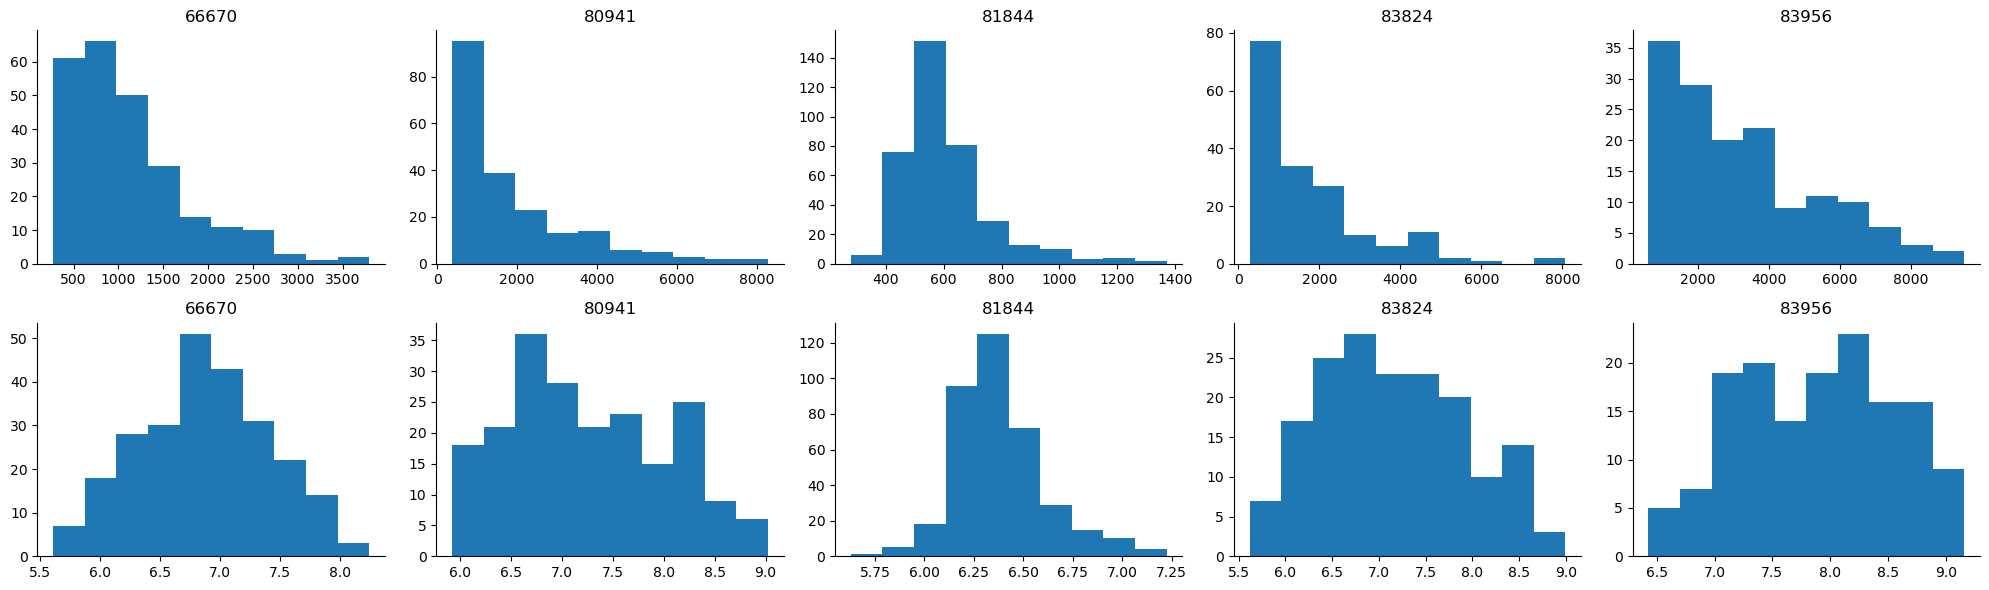

In [6]:
# 创建一个包含两个子图的 2 行 5 列布局
fig, axes = plt.subplots(2, 5, figsize=(20, 6))  

# 绘制第一个子图：原始的RT
df_first5.hist(column="RT", by="subject", ax=axes[0], figsize=(13, 3), layout=(1, 5))
for ax in axes[0]: 
    ax.tick_params(axis='x', rotation=0)

# 绘制第二个子图：logRT
df_first5.assign(logRT = np.log(df_first5['RT'])).hist(column="logRT", by="subject", ax=axes[1], figsize=(13, 3), layout=(1, 5))
for ax in axes[1]:  
    ax.tick_params(axis='x', rotation=0)

# 调整布局
plt.tight_layout()
sns.despine()
plt.show()

我们可以使用上节课学习的链接函数（link function）来将反应时数据转换为正态分布。

公式为：

$$
\begin{align*}
\eta = \log(RT)  \\
\eta \sim \mathcal{N}(\mu, \sigma)  \\
\end{align*}
$$

* 其中，$\eta$是反应时的对数，$\mu$和$\sigma$是正态分布的均值和标准差。


注意，由于 RT 经过对数变化后其范围缩小，因此我们对先验进行设置时需要对 $\mu$ 和 $\sigma$ 进行缩放，以保持反应时数据的范围。
* 从上图中可以看出，反应时数据经过对数转换后的范围为 [5,10]。
* 因此，先验 $\mu$ 可以设置为 $\mu ~$，先验 $\sigma$ 的可以设置为: 

$$\begin{align*}
\mu \sim \mathcal{N}(7.5, 5)  \\
\sigma \sim Exp(1)  \\
\end{align*}
$$


```python
with pm.Model() as log_RT_model:

    #定义beta_0
    mu = pm.Normal("mu", mu=7.5, sigma=5)  
    #定义sigma                  
    sigma = pm.Exponential("sigma", 1) 

    logRT = pm.math.log(df.RT)

    likelihood = pm.Normal("y_est", mu=mu, sigma=sigma, observed=logRT)  

    log_RT_model_trace = pm.sample(random_seed=84735)
```

<div style="padding-bottom: 50px;"></div>


### 数据的层级结构  

![Image Name](https://cdn.kesci.com/upload/soa517lrnb.jpeg?imageView2/0/w/960/h/960)  



* $j$来表示被试，$j \in \{1,2, \ldots, 5\}$  
* $i$来表示被试内部的每一个数据$i \in \{1,2,\ldots,n_j\}$  
* 每一个被试的数据可以被表示为$Y_{ij}$，表示第$j$个被试的第$i$个试次的反应时间  

$$  
Y := \left((Y_{11}, Y_{21}, \ldots, Y_{n_1,1}), (Y_{12}, Y_{22}, \ldots, Y_{n_2,2}), \ldots, (Y_{1,5}, Y_{2,5}, \ldots, Y_{n_{5},5})\right)  .  
$$  

🤔可以想象，如果我们忽略了数据的分组结构，则可能违反模型使用的前提。  

* 例如，由于反应来自同一个被试，数据点之间是相互关联的，在对被试的反应时使用回归模型时，需要考虑独立性假设是否被违反。  

面对这样的层级数据，我们有三种建模思路(对应三种不同的假设)：  
- 完全池化(complete pooling)  
- 非池化(no pooling)  
- 部分池化(patial pooling)  

## 完全池化(Complete pooling)模型  

* 在完全池化模型中，我们忽略个体的分组信息(Site)，认为这些个体直接来自一个更大的总体  

![Image Name](https://cdn.kesci.com/upload/soa54z159w.png?imageView2/0/w/960/h/960)  




我们可以使用正态模型来建立 complete pooled 模型：  

$$  
\begin{split}  
Y_{ij} | \mu, \sigma & \sim N(\mu, \sigma^2) \\  
\mu    & \sim N(7.5, 5^2) \\  
\sigma & \sim \text{Exp}(1) \\  
\end{split}  
$$  

**global parameters $\theta$**  

* $\mu$为反应时间在**总体**中的均值(global mean)  

* $\sigma$为反应时间均值在**总体**中的标准差(global standard deviation)  

![Image Name](https://cdn.kesci.com/upload/image/rmcx1f4dlx.png?imageView2/0/w/960/h/960)  

> 下图给出了数据中所有被试（n = 57）反应时间的分布情况，大部分反应时间集中在 1000-3000 毫秒 之间

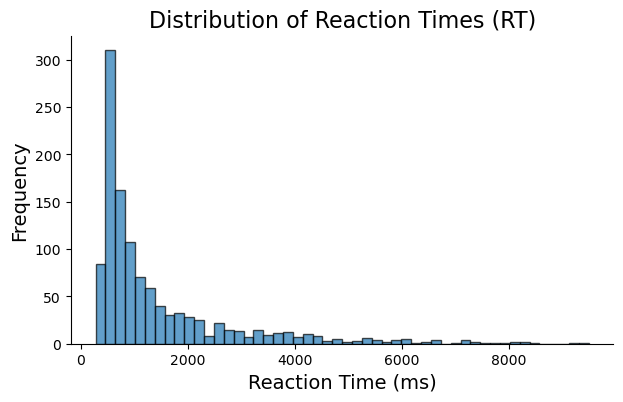

In [7]:
# 绘制所有被试的反应时间 (RT) 的分布图
plt.figure(figsize=(7, 4))
plt.hist(df_first5['RT'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Reaction Times (RT)', fontsize=16)
plt.xlabel('Reaction Time (ms)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
sns.despine()
plt.show()

### 模型定义及MCMC采样  

$$  
\begin{split}  
Y_{ij} | \mu, \sigma & \sim N(\mu, \sigma^2) \\  
\mu    & \sim N(7.5, 5^2) \\  
\sigma & \sim \text{Exp}(1) \\  
\end{split}  
$$  

根据公式使用 pymc 定义模型：

In [6]:
with pm.Model() as complete_pooled_model:

    # 对 RT 进行 log 变换
    log_RTs = pm.MutableData("log_RTs", np.log(df_first5['RT']))

    #定义 mu, 注意已经考虑到 RT 已经进行 log 转换
    mu = pm.Normal("mu", mu=7.5, sigma=5)  
    #定义sigma                  
    sigma = pm.Exponential("sigma", 1) 

    #定义似然：预测值y符合N(mu, sigma)分布；传入实际数据y 反应时间 log_RTs
    likelihood = pm.Normal("y_est", mu=mu, sigma=sigma, observed=log_RTs)  

    complete_trace = pm.sample(random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


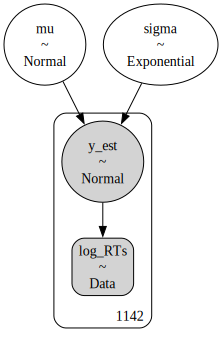

In [10]:
pm.model_to_graphviz(complete_pooled_model)

### 查看后验参数估计

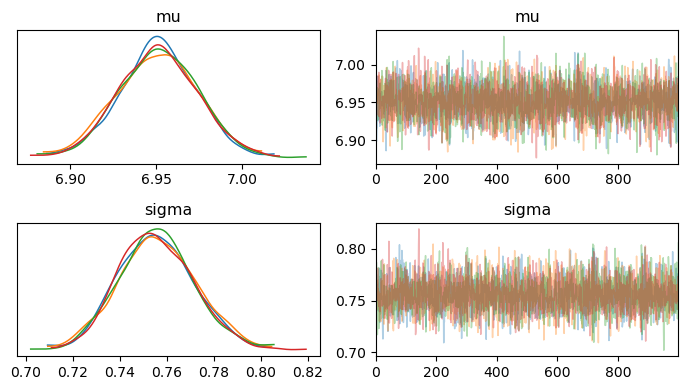

In [9]:
axes = az.plot_trace(complete_trace,
              compact=False,
              figsize=(7,4))
plt.tight_layout()
plt.show()

In [11]:
az.summary(complete_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,6.951,0.023,6.908,6.993,0.0,0.0,3935.0,2923.0,1.0
sigma,0.756,0.016,0.727,0.787,0.0,0.0,4570.0,2816.0,1.0


由于RT 已经进行了 log 变换，所以后验均值 mu 的真实值应为 1388。

使用以下公式可以将 mu 转换为 RT 的真实值：
$$
RT_{mean} = e^{\mu_{mean} + \sigma_{mean}^2/2}
$$

In [10]:
def inv_log(mu, sigma):
    return np.exp(mu + (sigma ** 2) / 2)

pred_rt = inv_log(6.950,0.756)
print("The estimated mean of RT is: ", pred_rt.round(3))

The estimated mean of RT is:  1388.207


In [12]:
print("The posterior mean of mu is: ", az.summary(complete_trace)["mean"][0].round(3))
print("The truth log RT mean is:", np.log(df_first5['RT']).mean().round(3))

The posterior mean of mu is:  6.951
The truth log RT mean is: 6.951


### 后验预测分布  

* 画出所有预测值的95%后验预测可信区间  

* 同时可以观察真实值落在可信区间的情况  

> (在之前的课件中已介绍过可信区间的绘制，主要借助`az.summary`生成后验预测总结的表格，并判断真实值是否落在可信区间内)

In [7]:
# 进行后验预测
complete_ppc = pm.sample_posterior_predictive(complete_trace,
                                              model=complete_pooled_model)

Sampling: [y_est]


Output()

In [8]:
# 定义函数，计算 95%hdi
def ppc_sum(ppc, data, y = "RT"):
    
    hdi_sum = az.summary(ppc, hdi_prob=0.95, kind="stats")
    hdi_sum["y"] = data[y].values
    hdi_sum["obs_id"] = data.reset_index(drop=True).index.values
    hdi_sum["subject"] = data["subject"].values

    return hdi_sum

In [9]:
# 计算后验预测的 95%hdi
complete_hdi_sum = ppc_sum(ppc = complete_ppc, data=df_first5)
complete_hdi_sum.head()

,mean,sd,hdi_2.5%,hdi_97.5%,y,obs_id,subject
y_est[0],6.970,0.750,5.554,8.506,1465,0,66670
y_est[1],6.939,0.749,5.528,8.436,1626,1,66670
y_est[2],6.967,0.757,5.510,8.433,993,2,66670
y_est[3],6.933,0.773,5.344,8.372,845,3,66670
y_est[4],6.949,0.745,5.521,8.442,1760,4,66670


由于 mean 和 hdi 也是收到对数化影响的, 因此需要对数据进行逆对数转换：

In [10]:
def inv_log(mu, sigma):
    return np.exp(mu + (sigma ** 2) / 2)

def inv_log_hdi_sum(hdi_sum):
    
    df = hdi_sum.copy()
    
    df["mean"] = inv_log(df["mean"], df["sd"])
    df.iloc[:, 2] = inv_log(df.iloc[:, 2], df["sd"])
    df.iloc[:, 3] = inv_log(df.iloc[:, 3], df["sd"])
    
    return df

complete_hdi_sum = inv_log_hdi_sum(complete_hdi_sum)

由于我们省略了分组信息，假测所有的观测值都来自同一正态分布，因此所有观测值的后验预测均值都是相似的  
* 纵坐标为反应时的范围  
* 横坐标代表每个观测值根据不同被试的排序  
* 黑色横线部分表示每个观测值的后验预测均值

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D  # 确保导入 Line2D

def ppc_plot(hdi_sum, ax=None, show_plot=True):

    df = hdi_sum.copy()
    
    df["obs_id"] = df.reset_index(drop=True).index

    # 选择一个Seaborn调色板
    palette = sns.color_palette("husl", len(df['subject'].unique()))

    # 创建一个颜色映射字典，深色和浅色
    color_map = {subject: (palette[i], sns.light_palette(palette[i], reverse=True)[3])
                for i, subject in enumerate(df['subject'].unique())}

    # 映射颜色到新列
    df['color_dark'] = df['subject'].map(lambda x: color_map[x][0])
    df['color_light'] = df['subject'].map(lambda x: color_map[x][1])

    # 根据是否落在可信区间内分配颜色
    df["color_dark"] = np.where(
        (df["y"] >= df["hdi_2.5%"]) & (df["y"] <= df["hdi_97.5%"]), 
        df["color_dark"], '#C00000'
    )

    # 设置画布
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 6))

    # 绘制 94% 的可信区间
    ax.vlines(df["obs_id"], 
                df["hdi_2.5%"], 
                df["hdi_97.5%"], 
                color=df["color_light"], 
                alpha=0.1, 
                label="94% HDI")

    # 各被试散点图数据
    ax.scatter(df["obs_id"], df["y"], 
                color=df["color_dark"],
                alpha=0.8, 
                zorder=2)

    # 绘制后验预测均值
    ax.scatter(df["obs_id"], df["mean"], 
                marker="_", 
                c='black', 
                alpha=0.7, 
                zorder=2, 
                label="Posterior mean")

    # 设置图例
    handles = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#C00000', markersize=10, label='Outside HDI'),
        Line2D([0], [0], color='gray', alpha=0.5, label='94% HDI'),
        Line2D([0], [0], marker='_', color='black', alpha=0.7, label='Posterior mean'),
    ]
    ax.legend(handles=handles, loc='upper right', bbox_to_anchor=(1.08, 1))

    # 设置 x 轴刻度
    count_per_subject = df.groupby("subject").size().values
    cumulative_count = count_per_subject.cumsum()
    xtick = cumulative_count - count_per_subject / 2
    ax.set_xticks(xtick, df["subject"].unique())

    # 设置图形标题和标签
    ax.set_title("Posterior Predictive Check (PPC) by Subject", fontsize=16)
    ax.set_xlabel("Subject ID", fontsize=14)
    ax.set_ylabel("Reaction Time (ms)", fontsize=14)

    if show_plot:
        sns.despine()
        plt.show()
    else:
        return ax

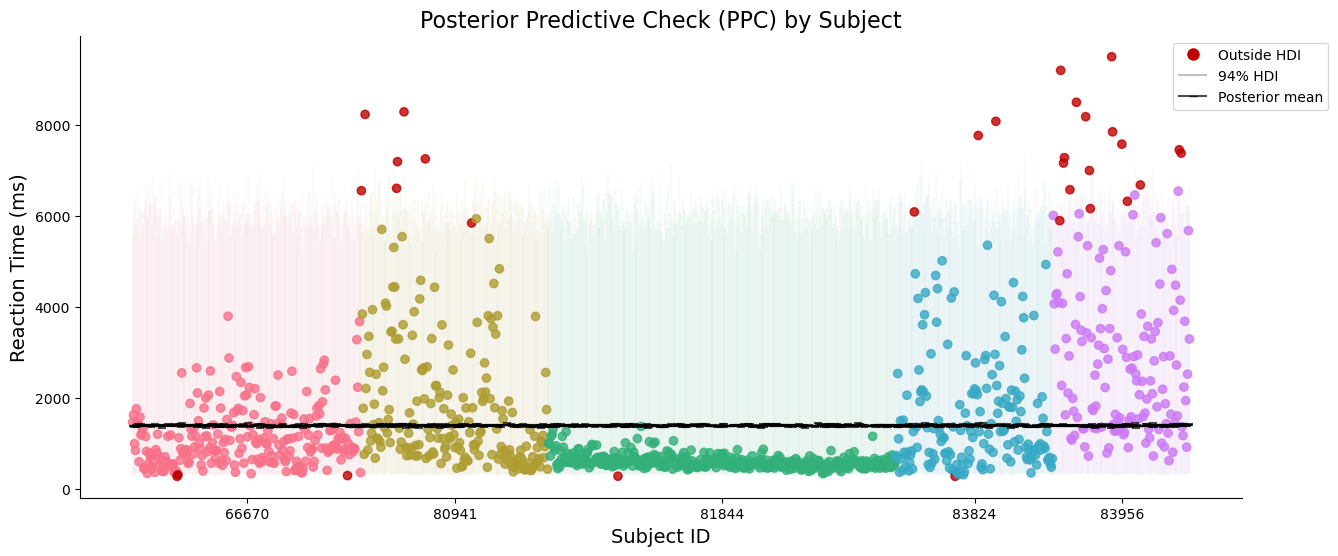

In [18]:
ppc_plot(hdi_sum=complete_hdi_sum)

## No pooling 非池化模型  

在complete pooled模型中，我们忽略了数据来自不同的被试这一事实  

现在我们考虑另外一种情况，我们**假设五个被试分别来自不同的分布，对五个被试进行不同的分析**  
* 注意：我们假定，每个被试的数据之间完全没有关联，不同被试之间彼此独立。  
* 从统计上讲，假定各被试之间的参数(例如均值$\mu$)没有关系，或者说是完全异质。  



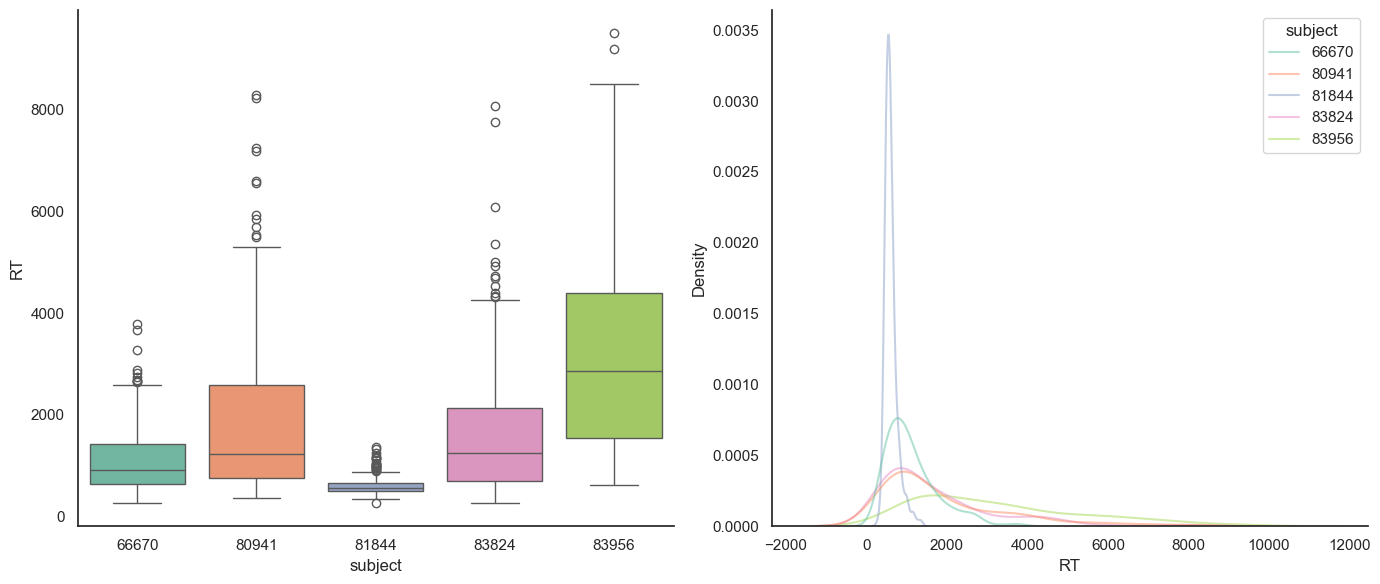

In [19]:
# 设置绘图风格
sns.set(style="white")

# 创建子图
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 左侧箱线图：显示每个被试的反应时间分布
sns.boxplot(
    data=df_first5,
    x="subject",
    y="RT",
    palette="Set2",
    ax=axes[0]
)

# 右侧核密度估计图：显示每个被试的反应时间密度分布
sns.kdeplot(
    data=df_first5,
    x="RT",
    hue="subject",
    palette="Set2",
    common_norm=False,
    alpha=0.5,
    ax=axes[1]
)

# 显示图形
plt.tight_layout()
sns.despine()
plt.show()


### Group-specific parameters  

* 在完全池化模型中，我们使用了正态分布的参数来自总体层面；  

* 在非池化模型中，我们认为正态分布的参数在组与组之间是不同的(group-specific) ---- 可以认为每个被试的数据对应一个独立的正态分布模型  

![Image Name](https://cdn.kesci.com/upload/soa6opcohm.png?imageView2/0/w/960/h/960)  

1. 使用 $\mu_j$ 来表示每个被试的反应时间均值  

    * 不同被试的$\mu_j$不同  

    * 同一被试内的trial服从以 $\mu_j$ 为均值的正态分布模型  

3. 同样，使用 $\sigma_j$ 来表示每个被试内部每个trial的反应时间的变异性  

    * 和 $\mu_j$ 类似，不同被试的 $\sigma_j$ 不同  
    * 同一被试内的个体服从以 $\sigma_j$ 为标准差的正态分布模型  

则对于被试 $j$ 内的每个trial来说，反应时间满足：  
$$  
Y_{ij} | \mu_j, \sigma \sim N(\mu_j, \sigma_j^2) \\  

\mu_j  \sim N(7.5, 5^2) \\  

\sigma_j \sim \text{Exp}(1) \\  
$$  
![Image Name](https://cdn.kesci.com/upload/soa6opcohm.png?imageView2/0/w/960/h/960)

### 模型定义及MCMC采样  

根据公式定义模型：  

$$  
Y_{ij} | \mu_j, \sigma \sim N(\mu_j, \sigma_j^2) \\  

\mu_j  \sim N(7.5, 5^2) \\  

\sigma_j \sim \text{Exp}(1) \\  
$$  

- 考虑到数据有5个被试，即 j = 1,2,3,4,5。因此，$\mu_j$ 和 $\sigma_j$ 也有5个值。  
- 在pymc中，我们可以通过定义坐标 coords 来实现 `pm.Normal(..., dims="subject")  
- 此外，每个trial的数据来自于某位被试，因此可以通过 `pm.MutableData("subject_id", mapped_subject_id, dims="obs_id")` 来定义每个trial数据 `obs_id` 和被试 `subject` 之间的映射。

In [11]:
# 建立被试 ID 映射表
subject_mapping = {subj_id: idx for idx, subj_id in enumerate(df_first5["subj_id"].unique())}

# 将被试 ID 转换为索引
mapped_subject_id = df_first5["subj_id"].map(subject_mapping).values

# 定义 pymc 模型坐标
coords = {
    "subject": df_first5["subj_id"].unique(),
    "obs_id": df_first5.index.values
}

with pm.Model(coords=coords) as no_pooled_model:
    
    # 对 RT 进行 log 变换
    log_RTs = pm.MutableData("log_RTs", np.log(df_first5['RT']))

    # 定义被试特定的均值和标准差
    mu = pm.Normal("mu",  mu=7.5, sigma=5, dims="subject")      
    sigma = pm.Exponential("sigma", 1, dims="subject")       

    # 定义观测数据的映射 (obs_id -> subject)
    subject_id = pm.MutableData("subject_id", mapped_subject_id, dims="obs_id")

    # 定义观测值 (obs_id 映射到对应 subject 的 mu 和 sigma)
    y = pm.Normal("y_est", mu=mu[subject_id], sigma=sigma[subject_id],
                  observed=log_RTs, dims="obs_id")

    # MCMC 采样
    no_pooled_trace = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


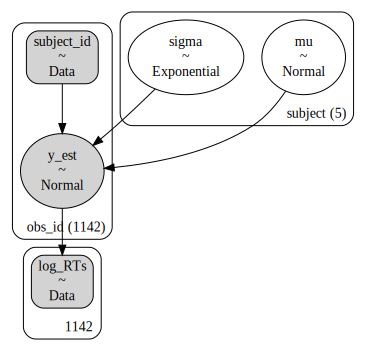

In [12]:
pm.model_to_graphviz(no_pooled_model)

### 查看后验参数估计  

- 可以发现，对于每个被试，均有不同的参数值 (包括 $\mu$ 和 $\sigma$)

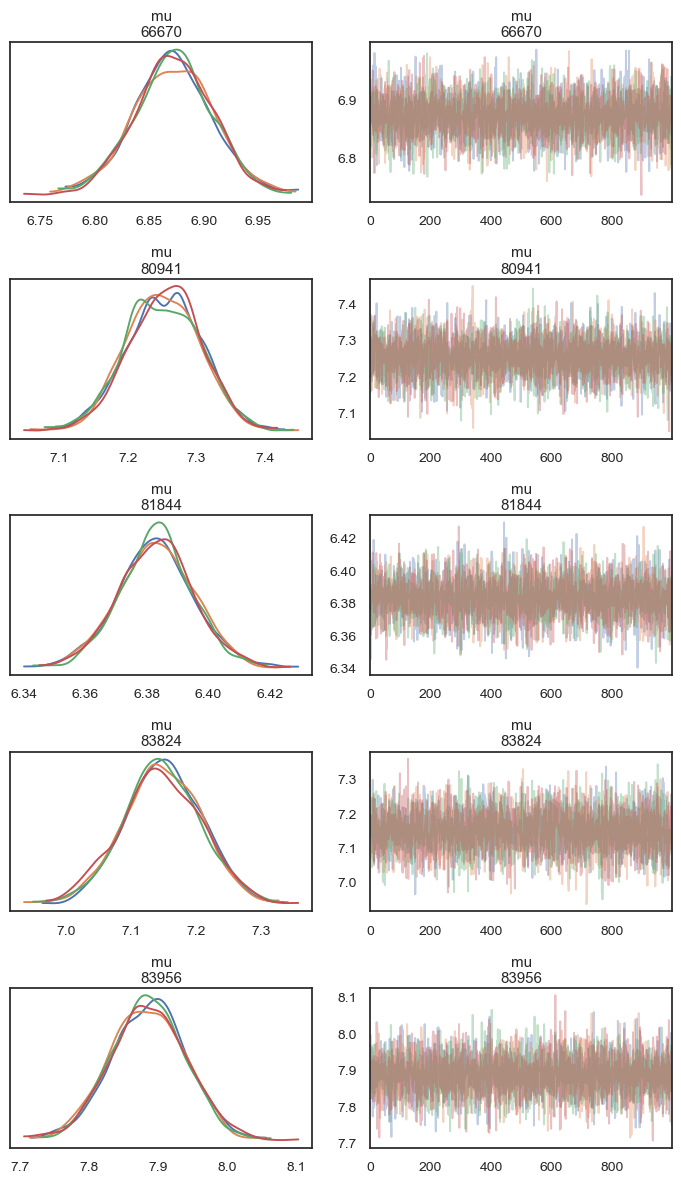

In [21]:
ax = az.plot_trace(
    no_pooled_trace,
    var_names=["mu"],
    filter_vars="like",
    compact=False,
    figsize=(7,12))
plt.tight_layout()

In [22]:
az.summary(no_pooled_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[66670],6.872,0.036,6.805,6.941,0.001,0.000,4793.0,2746.0,1.0
mu[80941],7.252,0.054,7.147,7.347,0.001,0.001,4913.0,3014.0,1.0
mu[81844],6.383,0.012,6.359,6.406,0.000,0.000,4822.0,3162.0,1.0
mu[83824],7.148,0.059,7.034,7.258,0.001,0.001,5004.0,3030.0,1.0
mu[83956],7.886,0.054,7.779,7.981,0.001,0.001,4404.0,2991.0,1.0
sigma[66670],0.554,0.025,0.506,0.601,0.000,0.000,4572.0,2982.0,1.0
sigma[80941],0.765,0.038,0.696,0.836,0.001,0.000,4805.0,3166.0,1.0
sigma[81844],0.232,0.009,0.215,0.247,0.000,0.000,4695.0,2831.0,1.0
sigma[83824],0.767,0.042,0.690,0.841,0.001,0.000,5219.0,3228.0,1.0
sigma[83956],0.663,0.038,0.599,0.736,0.000,0.000,5945.0,3261.0,1.0


### 后验预测分布

In [13]:
no_ppc = pm.sample_posterior_predictive(no_pooled_trace,
                                        model=no_pooled_model)

Sampling: [y_est]


Output()

In [14]:
no_hdi_sum = ppc_sum(ppc = no_ppc,
                data=df_first5)

进行对数转换：

In [15]:
no_hdi_sum = inv_log_hdi_sum(no_hdi_sum)

### 非池化模型的缺点  

可以看到在非池化模型中，每个组的均值与方差都是不同的，非池化模型充分考虑了每个组内部的情况，然而，这种模型的缺点可能包括：  

1. 在小样本数据上，非池化模型存在过拟合的风险；  

2. 非池化模型假设每个组都属于不同的分布，因此其得出的结果难以用来预测新组别的情况。

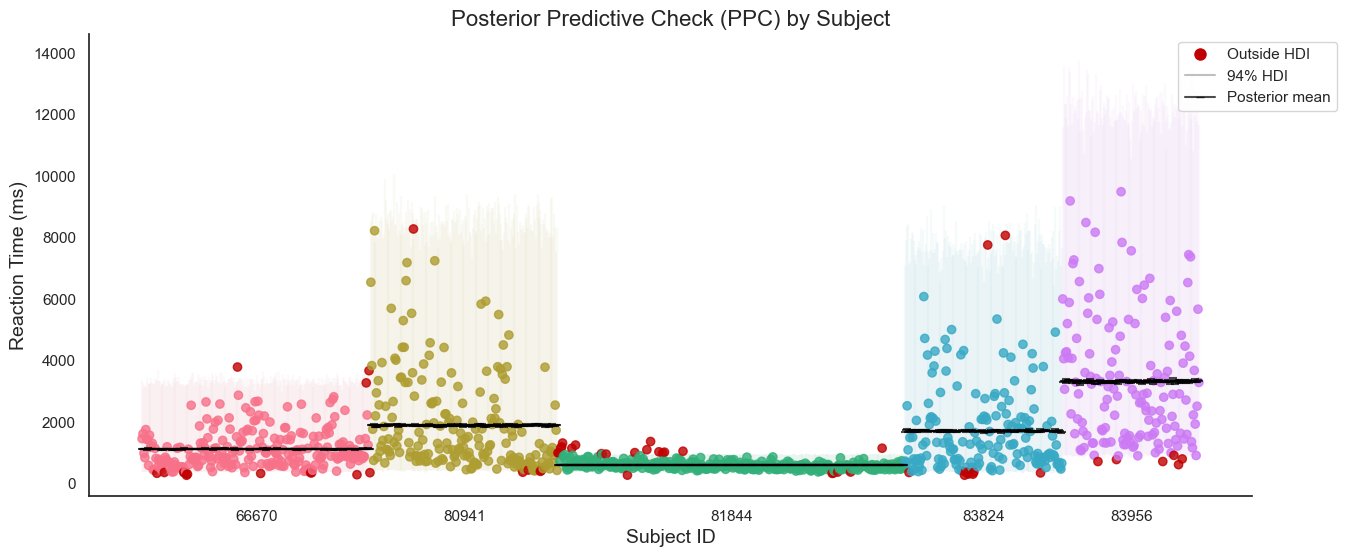

In [26]:
ppc_plot(hdi_sum=no_hdi_sum)

## Partial pooling  

- 完全池化模型仅考虑了trial之间的差异，没有考虑被试之间的差异。  
- 非池化模型考虑了被试的差异，但是容易受到不同被试内部极端数据的影响，忽视了不同被试做同一任务时可能存在的关系。  

部分池化 (Partial pooling)方法，是构建分层模型的关键。  
- 它假设，不同被试 (layer2) 来自于一个关于被试的总体 (Population)，被试形式的分布提供了对于组间变异(between variability)的解释。  
- 此外，不同trial的反应时  (layer1) 又来自于不同被试 (layer2) ，每个被试内部的trial数形成的分布提供了对于组内变异(within variability)的解释。  

![Image Name](https://cdn.kesci.com/upload/sooknhowtp.png?imageView2/0/w/960/h/960)


### 模型定义及MCMC采样  

层级模型的数学形式：  

$$  
\begin{array}{rll} 
\text{priors:} \;\; \;\; \;\; \;\; \mu  & \sim N(7.5, 5^2) & \\  
\sigma_y & \sim \text{Exp}(1)    & \\  
\sigma_\mu & \sim \text{Exp}(1)    & \\  
\mu_j | \mu, \sigma_\mu \stackrel{ind}{\sim} N(\mu, \sigma_\mu^2) \hspace{0.13in} & \text{(Layer2：被试水平)} \\  
\text{likelihood:} \;\; \;\; Y_{ij} | \mu_j, \sigma_y \sim N(\mu_j, \sigma_y^2) \hspace{0.05in} & \text{(Layer1：试次水平)} \\  
\end{array}  
$$

* $\mu_j$表示：第 $j$ 个被试的反应时间均值  

* $\sigma_\mu$表示：第 $j$ 个被试的反应时间标准差  


- 相对于非池化模型。部分池化模型的关键在于定义，被试参数在总体上的变异，即 `mu = pm.Normal("mu", mu=hyper_mu, sigma=var_mu, dims="subject")`  
- 其次，是相似于非池化模型，trial数的反应时间分布在被试上的变异 `pm.Normal("y_est", mu=mu[subject_id], sigma=var_y, observed=log_RTs, dims="obs_id")`  

In [16]:
# 建立被试 ID 映射表
subject_mapping = {subj_id: idx for idx, subj_id in enumerate(df_first5["subj_id"].unique())}

# 将被试 ID 转换为索引
mapped_subject_id = df_first5["subj_id"].map(subject_mapping).values

# 定义 pymc 模型坐标
coords = {
    "subject": df_first5["subj_id"].unique(),
    "obs_id": df_first5.index.values
}

with pm.Model(coords=coords) as partial_pooled_model:
    
    # 对 RT 进行 log 变换
    log_RTs = pm.MutableData("log_RTs", np.log(df_first5['RT']))

    # Hyperpriors,定义全局参数
    var_y = pm.Exponential("within_variability", 1)
    var_mu = pm.Exponential("between_variability", 1)
    hyper_mu = pm.Normal("hyper_mu", mu=7.5, sigma=5)

    # 定义被试参数
    mu = pm.Normal("mu", mu=hyper_mu, sigma=var_mu, dims="subject")
    #获得观测值对应的被试映射
    subject_id = pm.MutableData("subject_id", mapped_subject_id, dims="obs_id")
    # 定义 likelihood
    likelihood = pm.Normal("y_est", mu=mu[subject_id], sigma=var_y, observed=log_RTs, dims="obs_id")

    partial_trace = pm.sample(draws=5000,                   # 使用mcmc方法进行采样，draws为采样次数
                                tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                                chains=4,                     # 链数
                                discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                                random_seed=84735)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [within_variability, between_variability, hyper_mu, mu]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 28 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


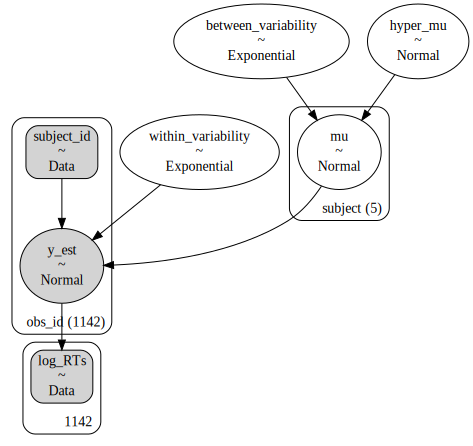

In [17]:
pm.model_to_graphviz(partial_pooled_model)

### 查看后验参数估计  

可以发现，  
- 不同被试的反应时间具有一致性，组内变异较小（较小的标准差）。  
- 被试均值存在显著差异，表明被试间的反应时间差异显著。

In [29]:
az.summary(partial_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
hyper_mu,7.113,0.343,6.466,7.759,0.003,0.002,14699.0,10360.0,1.0
mu[66670],6.873,0.036,6.806,6.941,0.000,0.000,29917.0,15098.0,1.0
mu[80941],7.251,0.041,7.174,7.328,0.000,0.000,29368.0,13911.0,1.0
mu[81844],6.385,0.030,6.329,6.441,0.000,0.000,29484.0,14332.0,1.0
mu[83824],7.148,0.044,7.067,7.231,0.000,0.000,27923.0,14156.0,1.0
mu[83956],7.880,0.048,7.792,7.972,0.000,0.000,29168.0,14239.0,1.0
within_variability,0.574,0.012,0.551,0.596,0.000,0.000,27184.0,14165.0,1.0
between_variability,0.701,0.320,0.285,1.253,0.003,0.002,14836.0,11460.0,1.0


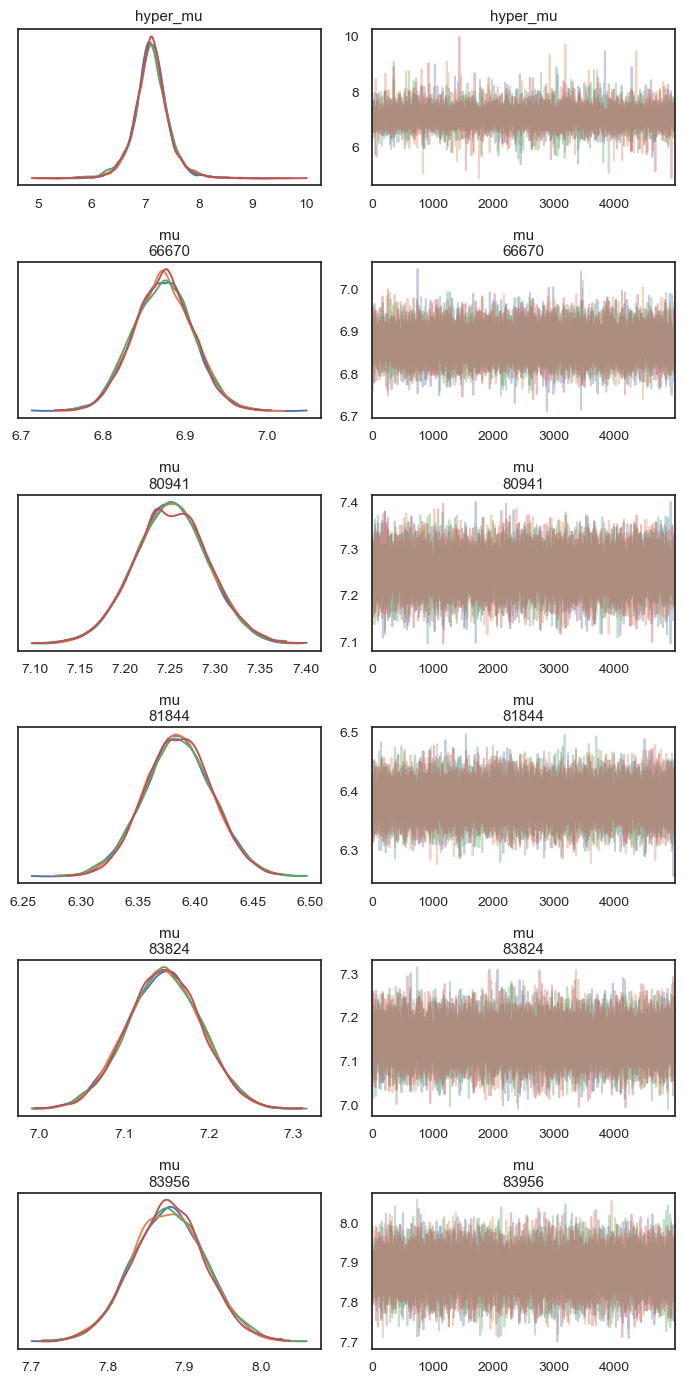

In [30]:
ax = az.plot_trace(
    partial_trace,
    var_names=["mu"],
    filter_vars="like",
    compact=False,
    figsize=(7,14))
plt.tight_layout()

### 后验预测分布  

* 可以看到相比于非池化模型，在层级模型中不同组的后验预测可信区间的长度、后验预测均值都更为接近

In [18]:
partial_ppc = pm.sample_posterior_predictive(partial_trace,
                                            model=partial_pooled_model)

partial_hdi_sum = ppc_sum(ppc=partial_ppc,
                  data=df_first5)     

Sampling: [y_est]


Output()

同样进行对数转换：

In [19]:
partial_hdi_sum = inv_log_hdi_sum(partial_hdi_sum)

可视化预测结果：

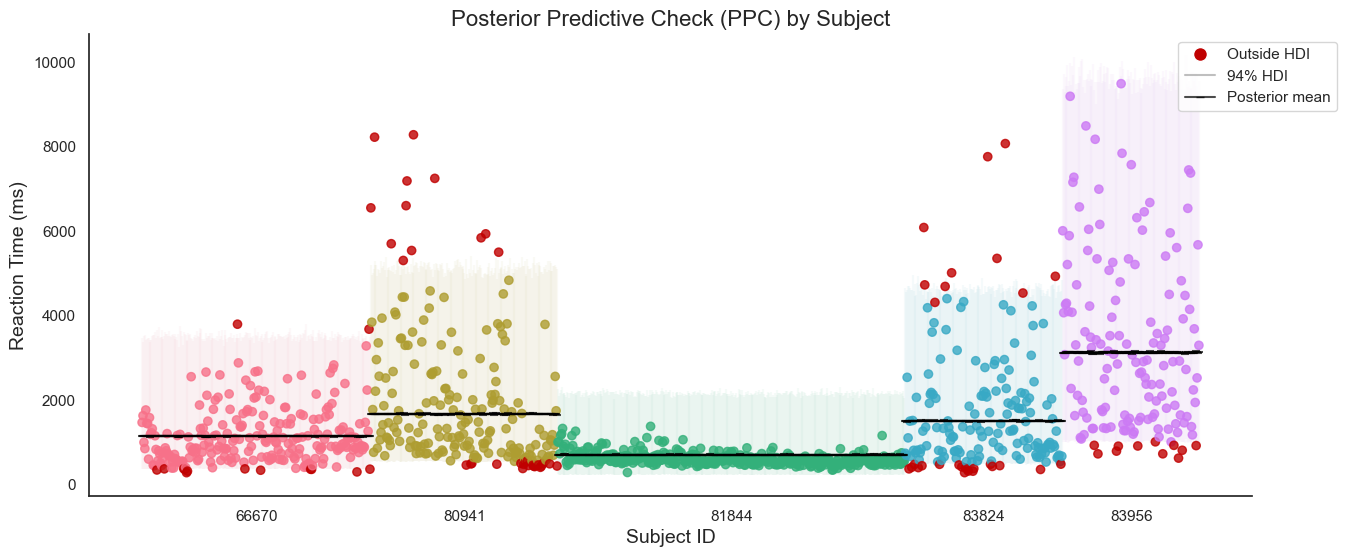

In [33]:
ppc_plot(hdi_sum=partial_hdi_sum)

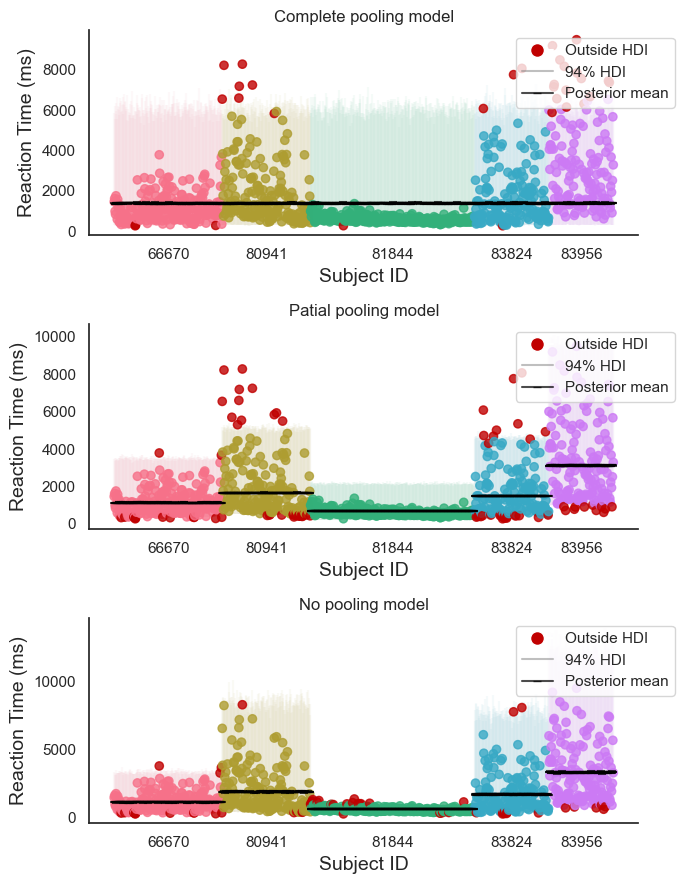

In [34]:
fig, axes = plt.subplots(3,1, figsize=(7,9))

ax = axes[0]
ax = ppc_plot(hdi_sum=complete_hdi_sum, ax = ax, show_plot=False)
ax.set_title("Complete pooling model")

ax = axes[1]
ax = ppc_plot(hdi_sum=partial_hdi_sum, ax = ax, show_plot=False)
ax.set_title("Patial pooling model")

ax = axes[2]
ax = ppc_plot(hdi_sum=no_hdi_sum, ax = ax, show_plot=False)
ax.set_title("No pooling model")

sns.despine()
plt.tight_layout()
plt.show()

## Within- vs between-group variability  

* 在完全池化模型中，变异性的来源只有一种，即个体观测值 $Y$ 在总体中的变异  ($\sigma$)  
* 在非池化模型中，变异来源分散在不同被试中，即个体观测值在不同被试中的变异 ($\sigma_j$)  

在部分池化模型中，我们可以把个体观测值$Y$的变异来源分解成两个部分：  
* 组内变异 $\sigma_y^2$  
* 组间变异 $\sigma_{\mu}^2$  

$$  
\text{Var}(Y_{ij}) = \sigma_y^2 + \sigma_{\mu}^2  
$$  

<div align="center">
  <img src="https://cdn.kesci.com/upload/sopzqb1xl1.png?imageView2/0/w/960/h/960" alt="Image">
</div>

类似于单因素方差分析  

$$  
\begin{split}  
\frac{\sigma^2_y}{\sigma^2_\mu + \sigma^2_y}  
& = \text{ $\text{Var}(Y_{ij})$ 可以被组内方差解释的部分} \\  
\frac{\sigma^2_\mu}{\sigma^2_\mu + \sigma^2_y}  
& = \text{$\text{Var}(Y_{ij})$ 可以被组间方差解释的部分} \\  
\end{split}  
$$  


* 组间方差远大于组内方差($\sigma_\mu > \sigma_y$)，那么组间方差可以解释大部分观测值的变异  
* 组间方差远小于组内方差($\sigma_\mu < \sigma_y$)，那么组与组之间的区别就不是很明显


* 此外，若组间方差远大于组内方差，则可以说明组内的变异性很小，组内分数高度相关  

$$  
\text{Cor}(Y_{ij}, Y_{kj}) = \frac{\sigma^2_\mu}{\sigma^2_\mu + \sigma^2_y}  
$$  

* 下图展示了三种组间方差与组内方差的分布情况(横轴为方差的大小，蓝色为组间方差，黑色为组内方差)  


![Image Name](https://cdn.kesci.com/upload/s5k6q39qp6.png?imageView2/0/w/700)  


- 组别越独特，$\sigma_{\mu}$ 相对越大，每**组内的相关性就越大**。  
- 图 (a) 中，组间变异是组内变异的4倍，此时组内相关性为 0.8，接近于 1。  
- 图 (c) 中，组间变异是组内变异的1/4倍，组内相关性为 0.2，接近 0。

我们可以使用`az.summary`来总结后验参数估计的情况，并计算组间组内变异和相关性

进行对数转换：

## Shrinkage & the bias-variance trade-off  

从下图和表格中可以发现，三个模型的关系：  
* 部分池化模型的超参数 (hyper_mu)的后验分布接近完全池化模型估计的参数 (mu)  
* 部分池化模型中对被试参数的估计 (mu[?]) 的后验分布接近非池化模型估计的参数 (mu[?])  
* 对于目前的被试来说，相比于非池化模型，部分池化模型中的参数 (mu[?]) 更加靠近完全池化模型，这就是**分层模型的收缩 (shrinkage) 现象**。  

In [35]:
# 提取三个模型参数后验，筛选中其中含有mu参数的部分
partial_stats = az.summary(partial_trace, var_names=["mu"], filter_vars = "like", kind="stats")
no_stats = az.summary(no_pooled_trace, var_names=["mu"], filter_vars = "like", kind="stats")
complete_stats = az.summary(complete_trace, var_names=["mu"], filter_vars = "like", kind="stats")

partial_stats = inv_log_hdi_sum(partial_stats)
no_stats = inv_log_hdi_sum(no_stats)
complete_stats = inv_log_hdi_sum(complete_stats)

# 设置一列，表明参数来源
complete_stats['source'] = 'Complete pool'
no_stats['source'] = 'No pool'
partial_stats['source'] = 'Partial pool'

# 合并三个模型的结果
df_compare = pd.concat([complete_stats.reset_index(),
                        no_stats.reset_index(),
                        partial_stats.reset_index()])

#设置索引，表明参数来源
df_compare.set_index(['source', df_compare.index], inplace=True)
df_compare

index         mean     sd       hdi_3%      hdi_97%
source                                                                  
Complete pool 0         mu  1044.469625  0.023  1000.509351  1089.271605
No pool       0  mu[66670]   965.501833  0.036   902.932681  1034.473623
              1  mu[80941]  1412.982503  0.054  1272.142798  1553.798722
              2  mu[81844]   591.742752  0.012   577.709993   605.510558
              3  mu[83824]  1273.775368  0.059  1136.536206  1421.887510
              4  mu[83956]  2663.664273  0.054  2393.370733  2929.122005
Partial pool  0   hyper_mu  1302.218334  0.343   681.860097  2484.494507
              1  mu[66670]   966.467817  0.036   903.836065  1034.473623
              2  mu[80941]  1410.698852  0.041  1306.151753  1523.614117
              3  mu[81844]   593.151591  0.030   560.848043   627.315748
              4  mu[83824]  1272.791756  0.044  1173.760528  1382.941457
              5  mu[83956]  2646.920056  0.048  2423.945831  2901.990036

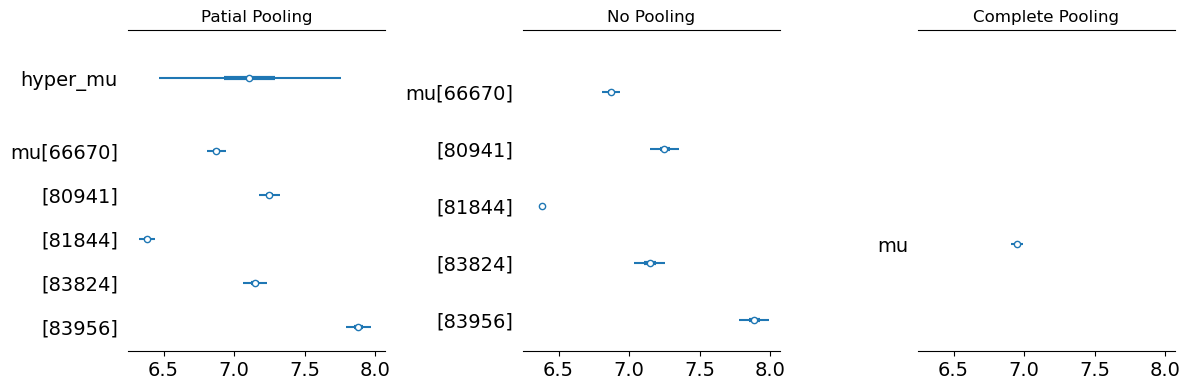

In [43]:
# 设置三个绘制坐标轴
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4), sharex=True)

# 绘制三个模型参数后验
az.plot_forest(partial_trace, var_names=["mu"], filter_vars = "like", combined=True, ax=ax1)
ax1.set_title("Patial Pooling")
az.plot_forest(no_pooled_trace, var_names=["mu"], filter_vars = "like", combined=True, ax=ax2)
ax2.set_title("No Pooling")
az.plot_forest(complete_trace, var_names=["mu"], filter_vars = "like", combined=True, ax=ax3)
ax3.set_title("Complete Pooling")

plt.tight_layout()
plt.show()

* 在完全池化模型中，对于每一个被试来说，后验估计均值都是相同的，在弱先验的情况下，后验估计均值约等于所有观测值的平均值  
$$  
\overline{y}_{\text{global}} = \frac{1}{n}\sum_{\text{all } i,j }y_{ij}  
$$  

* 在非池化模型中，对于每一个被试来说，其后验估计均值的估计只来自该组内部，在弱先验的情况下，后验估计均值约等于该组内所有观测值的平均值  
$$  
\overline{y}_j = \frac{1}{n_j}\sum_{i=1}^{n_j} y_{ij}  
$$  

* 在层级模型中，后验估计均值则是在完全池化和非池化模型中找到一个平衡，组间(group-specific)参数有可能更倾向完全池化模型，也有可能更倾向于非池化模型，这种现象被称为shrinkage  
> 当使用弱信息先验时，分层模型的后验平均预测结果（大致）是完全池化模型和非池化模型预测结果的加权平均  
$$  
\frac{\sigma^2_y}{\sigma^2_y + n_j \sigma^2_\mu} \overline{y}_{\text{global}} + \frac{n_j\sigma^2_\mu}{\sigma^2_y + n_j \sigma^2_\mu} \overline{y}_j  
$$  

* 我们可以分别绘制出每个观测值对应的后验预测均值，并观察这些后验预测均值在不同的模型之间发生了什么变化

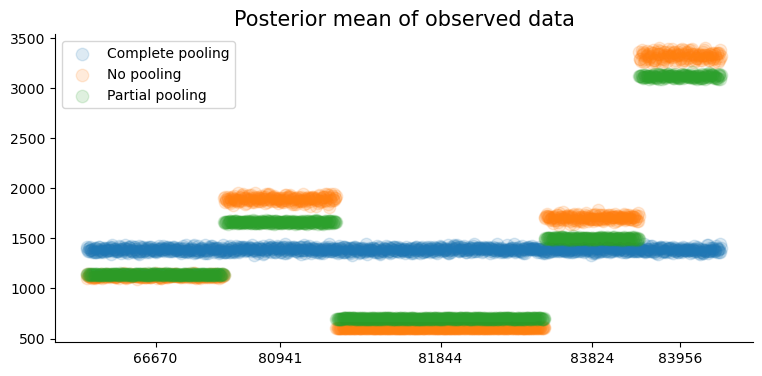

In [39]:
#设置画布大小1
plt.figure(figsize=(9,4))

#绘制完全池化模型下每个点对应的后验预测均值
plt.scatter(complete_hdi_sum["obs_id"],
            complete_hdi_sum["mean"],
            alpha=0.15,
            s=80,
            label="Complete pooling")

#绘制非池化模型下每个点对应的后验预测均值
plt.scatter(no_hdi_sum["obs_id"],
            no_hdi_sum["mean"],
            alpha=0.15,
            s=80,
            label="No pooling")

#绘制部分池化模型下每个点对应的后验预测均值
plt.scatter(partial_hdi_sum["obs_id"],
            partial_hdi_sum["mean"],
            alpha=0.15,
            s=80,
            label="Partial pooling")

#设置图例
plt.legend()

#计算每个被试的数据量，并根据数据量大小在x轴上进行刻度标识
count_per_subject = df_first5.groupby("subject").size().values
cumulative_count = count_per_subject.cumsum()
xtick = cumulative_count - count_per_subject / 2
plt.xticks(xtick,df_first5["subject"].unique())

#设置标题
plt.title("Posterior mean of observed data",
          fontsize=15)
sns.despine()

收缩是指在分层模型中，特定群体的局部趋势(各被试的估计结果)被拉向或收缩向全局趋势(所有数据的整体趋势)的现象。  

$$  
\frac{\sigma^2_y}{\sigma^2_y + n_j \sigma^2_\mu} \overline{y}_{\text{global}} + \frac{n_j\sigma^2_\mu}{\sigma^2_y + n_j \sigma^2_\mu} \overline{y}_j  
$$  

* 收缩的大小 (即完全池化模型均值和非池化模型均值的权重)，取决于被试的数量 $n_j$ 以及 组内和组间变异性（$\sigma_y$和 $\sigma_μ$）的比。  
* 当被试的数量越少时，缩减率会增加。即我们越来越依赖全局趋势来了解一个组别很少 (可能意味着不可靠)的结果。  
* 当组别内的变异性$\sigma_y$与组别间的变异性 $\sigma_μ$ 相比较大时，缩减会增加。即当各被试之间的差异很小时，我们会更依赖于用全局趋势来理解其中一个被试的数据。  

层次模型在完全池化和无池化之间取得了平衡，优势在于：  

1. 将对不同群体(被试)的观察结果推广到更广泛的总体中  
2. 在了解任何单个群体时，借用所有其他群体的信息  

这也导致了它的缺点：  
* 如果被试数量少，并且组内变异大，那么我们对于总体和不同组别(被试)的估计都可能存在偏差

**bias-variance trade-off 偏差-方差权衡**  


|               | 完全池化                       | 非池化                                 | 部分池化               |  
| ------------- | ------------------------------ | -------------------------------------- | ---------------------- |  
| 特点          | 仅考虑总体的变异，模型过于简单 | 仅考虑各组别的差异，结果难以推广到总体 | 同时考虑组间和组内变异 |  
| 偏差-方差权衡 | 有较高的偏差和较低的方差       | 较低的偏差和较高的方差                 | 更为平衡               |  


## 模型评估

在第十一课中，通过示例介绍了 MAE的计算方法。本节课中也将通过MAE指标对三个不同的模型进行评估，以比较它们的表现。

In [23]:
def calculate_mae(hdi_sum, obs = "y", pred = "mean"):
    """
    计算后验预测均值和 MAE (Median Absolute Error)。
    """

    # 提取后验预测值
    observed_data = hdi_sum[obs]
    posterior_predictive = hdi_sum[pred]
    
    # 计算 MAE（绝对误差的中位数）
    mae = np.median(np.abs(observed_data - posterior_predictive))
    
    return mae

根据MAE值的结果可以看出，部分池化模型的MAE值约为 376.01 ，是三种模型中误差最小的。

这表明部分池化模型的表现优于其他两种模型。


In [27]:
pd.DataFrame({
    "Complate Pooling Model": [calculate_mae(complete_hdi_sum)],
    "No Pooling Model": [calculate_mae(no_hdi_sum)],
    "Partilar Pooling Model": [calculate_mae(partial_hdi_sum)],
})

,Complate Pooling Model,No Pooling Model,Partilar Pooling Model
0,769.935022,402.799413,376.013831


## 预测新组的数据  

* 我们可以根据当前的层级模型对新组别的数据进行预测，如被试 31727。  

* 在pymc中，只要在`pm.sample_posterior_predictive`中传入层级模型的后验参数采样结果，即可以在层级模型的基础上对新数据生成预测  

* 预测结果储存在`.predictions`中

In [40]:
# 选择被试为"31727"的数据
new_data = df_raw[(df_raw.subject == 31727) & (df_raw['percentCoherence'] == 5)]

# 建立索引 'subj_id' 和 'obs_id'
new_data['subj_id'] = new_data['subject']
new_data['obs_id'] = new_data.groupby('subject').cumcount() + 1

new_data.head()

,subject,blkNum,trlNum,coherentDots,numberofDots,percentCoherence,winningDirection,response,correct,eventCount,averageFrameRate,RT,subj_id,obs_id
2,31727,2,3,2,40,5,left,right,0,15,15.322,979,31727,1
22,31727,3,8,2,40,5,left,right,0,40,14.276,2802,31727,2
24,31727,3,10,2,40,5,right,right,1,24,14.303,1678,31727,3
28,31727,3,14,2,40,5,right,right,1,19,14.559,1305,31727,4
30,31727,3,16,2,40,5,right,left,0,25,14.451,1730,31727,5


进行预测时，我们将使用新数据 new_data；以及先前模型计算出的参数，即：

$$
\begin{align*}
\mathcal{hyper\_mu} &= 7.105 \\
\mathcal{sd} &= 0.349 \\
\end{align*}
$$

In [41]:
# 建立被试 ID 映射表
subject_mapping = {subj_id: idx for idx, subj_id in enumerate(new_data["subj_id"].unique())}

# 将被试 ID 转换为索引
mapped_subject_id = new_data["subj_id"].map(subject_mapping).values

# 定义 pymc 模型坐标
new_coords = {
    "subject": new_data["subj_id"].unique(),
    "obs_id": new_data.index.values
}

with pm.Model(coords=new_coords) as partial_pooled_pred:
    
    # 对 RT 进行 log 变换
    log_RTs = pm.MutableData("log_RTs", np.log(new_data['RT']))

    # 定义新预测数据对应的新参数
    hyper_mu = pm.Normal("new_hyper_mu", mu=7.105, sigma=0.340)
    var_y = pm.Exponential("new_within_variability", 5)
    var_mu = pm.Exponential("new_between_variability", 5)

    # 定义被试参数
    new_mu = pm.Normal("new_mu", mu=hyper_mu, sigma=var_mu, dims="subject")
    #获得观测值对应的被试映射
    subject_id = pm.MutableData("subject_id", mapped_subject_id, dims="obs_id")
    
    # 定义 likelihood
    likelihood = pm.Normal("y_est", mu=new_mu[subject_id], sigma=var_y, observed=log_RTs, dims="obs_id")
    
    # 进行后验预测估计，注意使用的是上一个模型的后验参数估计，partial_trace
    pred_trace = pm.sample_posterior_predictive(partial_trace,
                                                var_names=["y_est"],
                                                predictions=True,
                                                random_seed=84735)                                          

Sampling: [new_between_variability, new_hyper_mu, new_mu, new_within_variability, y_est]


Output()

对预测数据进行转换并进行可视化：

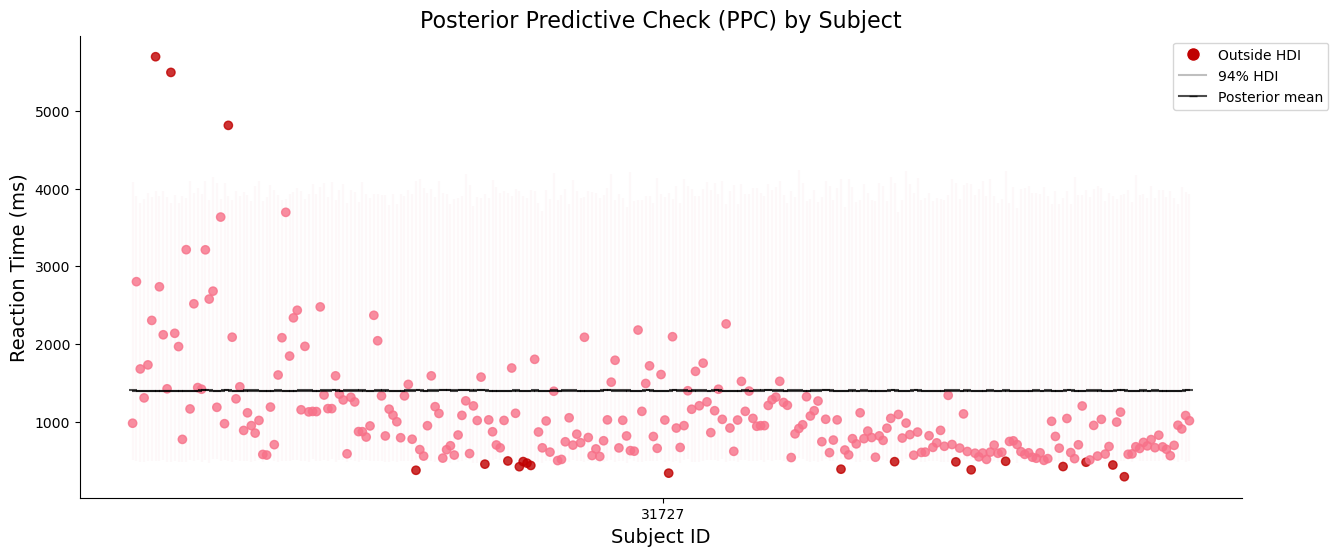

In [42]:
pred_hdi_sum = ppc_sum(ppc=pred_trace.predictions,data=new_data)
pred_hdi_sum = inv_log_hdi_sum(pred_hdi_sum)
ppc_plot(pred_hdi_sum)

## 开放式练习  

在本次的练习中，层级数据表现为来自多个被试的自我控制分数，你可以选择完善完全池化、非池化、部分池化模型的练习代码，也可以选择使用之前介绍过的bambi模型构建分层模型，并思考分层模型带来的收缩效应 (shrinkake)。  

🔔 针对Bambi构建分层模型的提示：  
1. 使用部分池化中的第一种公式构建分层模型时，提示：可使用`"scontrol ~ 0 + (1|Site)"`构建模型。  
2. 使用 `az.plot_forest` 绘制被试参数森林图。  

> * 数据来源: Hu, C.-P. et al. (2018). Raw data from the Human Penguin Project. Open Science Framework. https://doi.org/10.17605/OSF.IO/H52D3   
> * 自我控制量表来源：Tangney, J. P., Baumeister, R. F. & Boone, A. L. High self-control predicts good adjustment, less pathology, better grades, and interpersonal success. J. Pers. 72, 271–324 (2004).

In [1]:
# 导入 pymc 模型包，和 arviz 等分析工具 
import pymc as pm
import arviz as az
import seaborn as sns
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import ipywidgets
import bambi as bmb

# 忽略不必要的警告
import warnings
warnings.filterwarnings("ignore")

In [64]:
# 通过 pd.read_csv 加载数据 Data_Sum_HPP_Multi_Site_Share.csv
try:
  df_raw = pd.read_csv('/home/mw/input/bayes3797/Data_Sum_HPP_Multi_Site_Share.csv')
except:
  df_raw = pd.read_csv('data/Data_Sum_HPP_Multi_Site_Share.csv')

df_raw[["Site","scontrol"]]

,Site,scontrol
0,Bamberg,41
1,Bamberg,36
2,Bamberg,31
3,Bamberg,40
4,Bamberg,43
...,...,...
1518,Zurich,45
1519,Zurich,39
1520,Zurich,42
1521,Zurich,42


### 数据可视化  

将所有被试的自我控制分数进行可视化，可以发现：  

* 有的组存在较多极端值  

* 组与组之间的均值不同

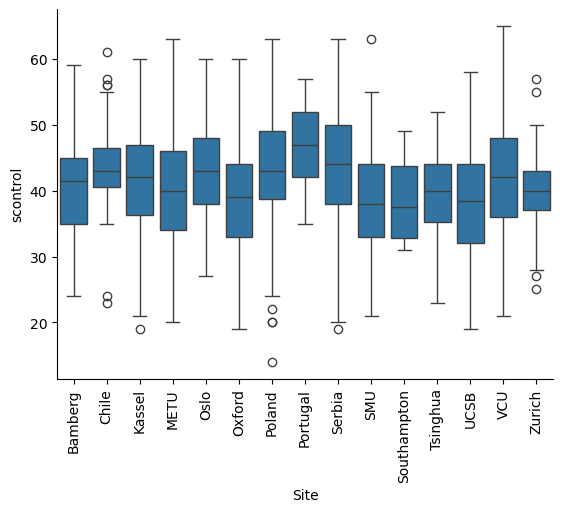

In [3]:
sns.boxplot(data=df_raw,
            x="Site",
            y="scontrol")

plt.xticks(rotation=90) 
sns.despine()
plt.show()

In [4]:
# 选取5个被试
first5_site = ['Southampton','METU','Kassel','Tsinghua','Oslo']
df_first5 = df_raw.query("Site in @first5_site")

#为被试生成索引，为被试生成索引
df_first5["site_idx"] = pd.factorize(df_first5.Site)[0]
df_first5["obs_id"] = range(len(df_first5))

#设置索引，方便之后调用数据
df_first5.set_index(['Site','obs_id'],inplace=True,drop=False)
df_first5.head(10)

age   anxiety  anxiety_r  artgluctot  attachhome  \
Site   obs_id                                                        
Kassel 0       1955.0  3.500000   0.323789         0.0    3.222222   
       1       1959.0  1.500000  -1.380456         0.0    4.444444   
       2       1965.0  1.333333  -1.522476         0.0    3.666667   
       3       1966.0  3.222222   0.087088         0.0    4.333333   
       4       1969.0  3.444444   0.276448         0.0    3.555556   
       5       1976.0  2.444444  -0.575674         0.0    4.555556   
       6       1979.0  3.500000   0.323789         0.0    4.111111   
       7       1979.0  1.444444  -1.427796         0.0    4.777778   
       8       1980.0  2.888889  -0.196953         0.0    4.111111   
       9       1981.0  4.555556   1.223251         0.0    4.777778   

               attachphone  AvgHumidity  avgtemp  avoidance  avoidance_r  ...  \
Site   obs_id                                                             ...   
Kassel 0          3.666667         89.0   36.300   3.777778     1.061474  ...   
       1          2.111111          NaN   36.600   2.722222    -0.124879  ...   
       2          2.000000          NaN   35.450   2.611111    -0.249759  ...   
       3          1.000000          NaN   36.630   3.166667     0.374638  ...   
       4          1.444444         69.0   36.465   3.222222     0.437077  ...   
       5          1.444444         73.0   36.500   2.222222    -0.686836  ...   
       6          2.777778         68.0   35.300   3.555556     0.811715  ...   
       7          3.000000         54.0   36.100   2.222222    -0.686836  ...   
       8          2.333333          NaN   36.400   3.388889     0.624396  ...   
       9          3.333333         61.0   36.750   4.000000     1.311232  ...   

               sex    Site  smoke  socialdiversity  socialembedded  socTherm  \
Site   obs_id                                                                  
Kassel 0       1.0  Kassel    2.0                6               3       3.0   
       1       2.0  Kassel    2.0                7               4       2.4   
       2       1.0  Kassel    2.0                5               2       3.8   
       3       2.0  Kassel    2.0                9               2       3.6   
       4       2.0  Kassel    2.0               11               3       2.2   
       5       2.0  Kassel    2.0               12               3       3.2   
       6       1.0  Kassel    2.0                7               2       2.8   
       7       2.0  Kassel    2.0                8               2       3.4   
       8       1.0  Kassel    1.0                9               4       2.8   
       9       2.0  Kassel    2.0                9               3       2.6   

               soliTherm  stress  site_idx  obs_id  
Site   obs_id                                       
Kassel 0           3.125      30         0       0  
       1           3.125      30         0       1  
       2           2.375      31         0       2  
       3           2.875      47         0       3  
       4           2.750      50         0       4  
       5           2.625      42         0       5  
       6           4.125      37         0       6  
       7           2.750      33         0       7  
       8           3.750      42         0       8  
       9           3.875      40         0       9  

[10 rows x 39 columns]

### 模型定义及MCMC采样  

$$  
\begin{split}  
Y_{ij} | \mu, \sigma & \sim N(\mu, \sigma^2) \\  
\mu    & \sim N(0, 50^2) \\  
\sigma & \sim \text{Exp}(1) \\  
\end{split}  
$$  

根据公式使用 pymc 定义模型：

In [ ]:
##--------------------------------------------------
#      提示：对...中的内容进行修改
#---------------------------------------------------

with pm.Model() as complete_pooled_model:

    #定义beta_0
    mu = pm.Normal("mu", mu=..., sigma=...)  
    #定义sigma                  
    sigma = pm.Exponential(...)       

    #定义似然：预测值y符合N(mu, sigma)分布；传入实际数据y 自我控制水平 df_first5.scontrol

    likelihood = pm.Normal(...)   

    # 进行采样，默认为 chains=4, samples=1000,burn=1000
    complete_trace = pm.sample(random_seed=84735)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [ ]:
az.plot_trace(complete_trace,
              compact=False,
              figsize=(15,6))

In [ ]:
az.summary(complete_trace)

In [ ]:
##--------------------------------------------------
#      提示：对...中的内容进行修改
#---------------------------------------------------

# 进行后验预测
complete_ppc = pm.sample_posterior_predictive(...)

Sampling: [y_est]


Output()

In [ ]:
# 定义函数，计算 95%hdi
def ppc_sum(ppc, data):
    
    hdi_sum = az.summary(ppc, hdi_prob=0.95)
    hdi_sum["obs_id"] = data["obs_id"].values
    hdi_sum["y"] = data["scontrol"].values
    hdi_sum["site"] = data["Site"].values

    return hdi_sum

# 计算后验预测的 95%hdi
complete_hdi_sum = ppc_sum(ppc = complete_ppc, data=df_first5)
complete_hdi_sum

In [9]:
# 定义函数绘制超出 95%hdi 的点
from matplotlib.lines import Line2D

def ppc_plot(hdi_sum):
    fig, ax =  plt.subplots(figsize=(15,6))

    #生成颜色条件，根据被试生成不同的颜色（可信区间）
    unique_sites = hdi_sum["site"].unique()
    conditions=[]
    colors=[]
    for i, site in enumerate(unique_sites):
        condition = hdi_sum["site"] == site
        conditions.append(condition)
        color = f"C{i}"
        colors.append(color)
        
    hdi_colors = np.select(conditions,colors)
    #绘制94%的可信区间
    HDI = ax.vlines(hdi_sum["obs_id"], 
            hdi_sum["hdi_2.5%"], hdi_sum["hdi_97.5%"], 
            color=hdi_colors, 
            alpha=0.5,
            label="94% HDI")
    #绘制后验预测均值
    pos_mean = ax.scatter(hdi_sum["obs_id"], hdi_sum["mean"],
            marker="_",
            c = 'black',
            alpha=0.2,
            zorder = 2,
            label="Posterior mean")
    #根据是否落在可信区间内选择不同的颜色
    colors = np.where((hdi_sum["y"] >= hdi_sum["hdi_2.5%"]) & (hdi_sum["y"] <= hdi_sum["hdi_97.5%"]), 
                    '#2F5597', '#C00000')
    #绘制真实值
    ax.scatter(hdi_sum["obs_id"], hdi_sum["y"],
            c = colors,
            alpha=0.7,
            zorder = 2)
    # 设置图例的颜色、形状、名称
    legend_color = ['#2F5597', '#C00000']
    handles = [plt.Line2D([0], [0], 
                        marker='o', 
                        color='w', 
                        markerfacecolor=color, markersize=10) for color in legend_color]
    handles += [HDI]
    handles += [pos_mean]
    labels = ['Within HDI', 'Outside HDI','94%HDI','Posterior mean']

    plt.legend(handles=handles, 
               labels=labels,
               loc='upper right',
               bbox_to_anchor=(1.08, 1))
    # 设置x轴的刻度，根据每个类别的数量确定刻度位置
    count_per_site = hdi_sum.groupby("site").size().values
    cumulative_count = count_per_site.cumsum()
    xtick = cumulative_count - count_per_site / 2
    plt.xticks(xtick, hdi_sum["site"].unique())

    sns.despine()

由于我们省略了分组信息，假测所有的观测值都来自同一正态分布，因此所有观测值的后验预测均值都是相似的  
* 纵坐标为自我控制分数的范围  
* 横坐标代表每个观测值的排序  
* 横线部分表示每个观测值的后验预测均值

In [ ]:
##--------------------------------------------------
#      提示：对...中的内容进行修改
#---------------------------------------------------

ppc_plot(...)

## No pooling 非池化模型  

在complete pooled模型中，我们忽略了数据来自不同的被试这一事实  

现在我们考虑另外一种情况，我们**假设五个被试分别来自不同的分布，对五个被试进行不同的分析**  
* 注意：我们假定，各被试数据之间完全没有关联，不同被试之间彼此独立。  
* 从统计上讲，假定各被试之间的参数(例如均值$\mu$)没有关系，或者说是完全异质。  

### Group-specific parameters  

* 在完全池化模型中，我们使用了正态分布的参数来自总体层面；  

* 在非池化模型中，我们认为正态分布的参数在组与组之间是不同的(group-specific) ---- 可以认为么个被试的数据对应一个独立的正态分布模型  

![Image Name](https://cdn.kesci.com/upload/s5eh3sji4k.png?imageView2/0/w/960/h/960)  

1. 使用 $\mu_j$ 来表示每个被试的自我控制分数均值  

    * 不同被试的$\mu_j$不同  

    * 同一被试内的个体服从以 $\mu_j$ 为均值的正态分布模型  

3. 同样，使用 $\sigma_j$ 来表示每个被试内部自我控制分数的变异性  

    * 和 $\mu_j$ 类似，不同被试的 $\sigma_j$ 不同  
    * 同一被试内的个体服从以 $\sigma_j$ 为标准差的正态分布模型  


则对于被试 $j$ 内的个体来说，自我控制分数满足：  
$$  
Y_{ij} | \mu_j, \sigma \sim N(\mu_j, \sigma_j^2) \\  

\mu_j  \sim N(0, 50^2) \\  

\sigma_j \sim \text{Exp}(1) \\  
$$  

![Image Name](https://cdn.kesci.com/upload/s5eh3sji4k.png?imageView2/0/w/960/h/960)  

### 模型定义及MCMC采样  

根据公式定义模型：  

$$  
Y_{ij} | \mu_j, \sigma \sim N(\mu_j, \sigma_j^2) \\  

\mu_j  \sim N(0, 50^2) \\  

\sigma_j \sim \text{Exp}(1) \\  
$$  

- 考虑到数据有5个被试，即 j = 1,2,3,4,5。因此，$\mu_j$ 和 $\sigma_j$ 也有5个值。  
- 在pymc中，我们可以通过定义坐标 coords 来实现 `pm.Normal(..., dims="site")  
- 此外，每个个体的数据来自于某个被试，因此可以通过 `pm.MutableData("site", df_first5.site_idx, dims="obs_id")` 来定义个体数据 `obs_id` 和被试 `site` 之间的映射。

In [ ]:
##--------------------------------------------------
#      提示：对...中的内容进行修改
#---------------------------------------------------

coords = {"site": df_first5["Site"].unique(),
          "obs_id": df_first5.obs_id}

with pm.Model(coords=coords) as no_pooled_model:

    #定义mu，指定dims="site"，生成不同的mu 
    mu = pm.Normal(...)                  
    #定义sigma，指定dims="site"，生成不同的sigma
    sigma = pm.Exponential(...)            
    #获得观测值对应的被试映射
    site = pm.MutableData(...) 
    # 定义 likelihood
    likelihood = pm.Normal(...)

    no_pooled_trace = pm.sample(random_seed=84735)

### 查看后验参数估计  

- 可以发现，对于每个被试，均有不同的参数值 (包括 $\mu$ 和 $\sigma$)

In [ ]:
##--------------------------------------------------
#      提示：对...中的内容进行修改
#---------------------------------------------------

ax = az.plot_trace(
    no_pooled_trace,
    compact=False,
    figsize=(20,50))

az.summary(...)

### 后验预测分布

In [ ]:
##--------------------------------------------------
#      提示：对...中的内容进行修改
#---------------------------------------------------

no_ppc = pm.sample_posterior_predictive(...)

In [ ]:
no_hdi_sum = ppc_sum(ppc = no_ppc,
                data=df_first5)

In [ ]:
##--------------------------------------------------
#      提示：对...中的内容进行修改
#---------------------------------------------------

ppc_plot(...)

## 部分池化模型  

层级模型的数学形式：  

$$  
\begin{array}{lrl}  
\text{Layer 1:} \hspace{0.5in} Y_{ij} | \mu_j, \sigma_y \sim N(\mu_j, \sigma_y^2) \hspace{0.05in} \text{根据被试均值生成个体数据}\\  

\text{Layer 2:} \hspace{0.5in} \mu_j | \mu, \sigma_\mu \stackrel{ind}{\sim} N(\mu, \sigma_\mu^2) \hspace{0.13in} \text{生成不同被试的均值}\\  

\text{Layer 3:}  \hspace{0.5in}\mu,\sigma_y,\sigma_\mu \hspace{0.85in}{超参数}\\  
\hspace{1in}\mu \sim N(40, 20^2) \\  
\hspace{1in}\sigma_y \sim \text{Exp}(1) \text{自我控制分数在组内的变异性} \\  
\hspace{1in} \sigma_\mu \sim \text{Exp}(1) \text{均值在组间的变异性} \\  
\end{array}  
$$  


1. 在最上层：  
    * 使用$\mu$来表示总体的$Y$(global average)，即总体而言，自我控制分数的均值  
    * 使用$\sigma_\mu$来表示组与组之间在$Y$均值上的变异性  
    * 使用$\sigma_y$来表示每个组内部$Y$的变异性(这里我们假设每个组内部的变异性相同)  
2. 在第二层：  
    * 使用$\mu_j$来表示每个组$Y$的均值，而$\mu_j$服从$N(\mu, \sigma_\mu^2)$，这两个参数是从上一层得到的  
3. 在第三层：  
    * 使用$Y_{ij}$来表示组内每个个体的$Y$，而$Y_{ij}$服从$N(\mu_j, \sigma_y^2)$，这两个参数是从上一层得到的  

![Image Name](https://cdn.kesci.com/upload/s5enwlkkz8.png?imageView2/0/w/500/h/500)  


### 模型定义及MCMC采样  

根据公式定义模型：  

$$  
\begin{array}{lrl}  
\text{Layer 1:} \hspace{0.5in} Y_{ij} | \mu_j, \sigma_y \sim N(\mu_j, \sigma_y^2) \hspace{0.05in} \text{根据被试均值生成个体数据}\\  

\text{Layer 2:} \hspace{0.5in} \mu_j | \mu, \sigma_\mu \stackrel{ind}{\sim} N(\mu, \sigma_\mu^2) \hspace{0.13in} \text{生成不同被试的均值}\\  

\text{Layer 3:}  \hspace{0.5in}\mu,\sigma_y,\sigma_\mu \hspace{0.85in}{超参数}\\  
\hspace{1in}\mu \sim N(40, 20^2) \\  
\hspace{1in}\sigma_y \sim \text{Exp}(1) \text{自我控制分数在组内的变异性} \\  
\hspace{1in} \sigma_\mu \sim \text{Exp}(1) \text{均值在组间的变异性} \\  
\end{array}  
$$  

- 相对于非池化模型。部分池化模型的关键在于定义，被试参数在总体上的变异，即 `mu = pm.Normal("mu", mu=hyper_mu, sigma=var_mu, dims="site")`  
- 其次，是相似于非池化模型，个体数据在不同被试分布上的变异 `pm.Normal("y_est", mu=mu[site], sigma=var_y, observed=df_first5.scontrol, dims="obs_id")`  



In [ ]:
##--------------------------------------------------
#      提示：对...中的内容进行修改
#---------------------------------------------------


with pm.Model(coords=coords) as partial_pooled_model:
    # Hyperpriors,定义全局参数
    var_y = pm.Exponential(...)
    var_mu = pm.Exponential(...)
    hyper_mu = pm.Normal(...)
    # 定义被试参数
    mu = pm.Normal(...)
    #获得观测值对应的被试映射
    site = pm.MutableData(...)
    # 定义 likelihood
    likelihood = pm.Normal(...)

    partial_trace = pm.sample(draws=5000,                   # 使用mcmc方法进行采样，draws为采样次数
                                tune=1000,                    # tune为调整采样策略的次数，可以决定这些结果是否要被保留
                                chains=4,                     # 链数
                                discard_tuned_samples= True,  # tune的结果将在采样结束后被丢弃
                                random_seed=84735)

### 查看后验参数估计  

In [ ]:
##--------------------------------------------------
#      提示：对...中的内容进行修改
#---------------------------------------------------

az.summary(...)

In [ ]:
##--------------------------------------------------
#      提示：对...中的内容进行修改
#---------------------------------------------------

with partial_pooled_model:
    az.plot_trace(partial_trace,
                  compact=False,
                  figsize=(20,40))

#### 计算组间组内变异和相关性

In [ ]:
##--------------------------------------------------
#      提示：对...中的内容进行修改
#---------------------------------------------------

# 提取组间和组内变异
partial_para_sum = az.summary(partial_trace)
between_sd = partial_para_sum.loc[...]
within_sd = partial_para_sum.loc[...]

# 计算变异占比
var = between_sd**2 + within_sd**2
print("被组间方差所解释的部分：", between_sd**2/var)
print("被组内方差所解释的部分：", within_sd**2/var)
print("组内相关：",between_sd**2/var)

### 后验预测分布  

* 可以看到相比于非池化模型，在层级模型中不同组的后验预测可信区间的长度、后验预测均值都更为接近

In [ ]:
##--------------------------------------------------
#      提示：对...中的内容进行修改
#---------------------------------------------------

partial_ppc = pm.sample_posterior_predictive(...,
                                            model=...)
partial_hdi_sum = ppc_sum(ppc=...,
                  data=...)     

In [ ]:
##--------------------------------------------------
#      提示：对...中的内容进行修改
#---------------------------------------------------

ppc_plot(hdi_sum=...)

In [ ]:
##--------------------------------------------------
#      提示：对...中的内容进行修改
#---------------------------------------------------

az.summary(...)